NAME: __Nigel Mansell__

# Homework 2

### Objectives
* Object orientation in Python
* Constructing Data Pre-processing Pipelines
  + Imputing
  + Filtering
  + Simple Numerical Methods
* Do not save work within the ml_practices folder
  + create a folder in your home directory for assignments, and copy the templates there  

### General References
* [Sci-kit Learn Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Sci-kit Learn Impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)
* [Sci-kit Learn Preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [Pandas Interpolate](https://pandas.pydata.org/pandas-docs/version/0.16/generated/pandas.DataFrame.interpolate.html)
* [Pandas fillna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

### Hand-In Procedure
* Execute all cells so they are showing correct results
* Notebook:
  + Submit this file (.ipynb) to the Canvas HW0 dropbox
* PDF:
  + File/Export Notebook As/PDF -> Produces a copy of the notebook in PDF format
  + Submit the PDF file to the Gradescope HW0 dropbox

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

FIGWIDTH = 10
FIGHEIGHT = 2

%matplotlib inline

# LOAD DATA

In [2]:
fname = '~/demo/data/subject_k1_w10_hw2.csv'

#makes a dataframe from file and prints the info
baby_data_raw = pd.read_csv(fname)
baby_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
time             15000 non-null float64
left_wrist_x     13458 non-null float64
left_wrist_y     13454 non-null float64
left_wrist_z     13454 non-null float64
right_wrist_x    13514 non-null float64
right_wrist_y    13514 non-null float64
right_wrist_z    13514 non-null float64
dtypes: float64(7)
memory usage: 820.4 KB


In [3]:
""" TODO
Call describe() on the data to get summary statistics
"""
#calling describe on dataframe
baby_data_raw.describe()


,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z
count,15000.000000,13458.000000,13454.000000,13454.000000,13514.000000,13514.000000,13514.000000
mean,149.990000,0.243580,0.162076,-0.044767,0.271218,-0.120768,-0.207248
std,86.605427,0.084823,0.093114,0.060566,0.055190,0.047123,0.054263
min,0.000000,0.027525,-0.046680,-0.186060,0.081230,-0.275120,-0.311197
25%,74.995000,0.177911,0.096319,-0.082849,0.238649,-0.140773,-0.245453
50%,149.990000,0.251879,0.154445,-0.045112,0.277340,-0.111330,-0.216992
75%,224.985000,0.308732,0.245144,-0.004720,0.314673,-0.085764,-0.158773
max,299.980000,0.389957,0.334027,0.147053,0.396959,-0.040851,-0.007693


In [4]:
""" TODO
Call head() on the data to observe the first few examples
"""

#calling head on dataframe
baby_data_raw.head()


,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z
0,0.00,NaN,0.293503,-0.092803,0.314738,-0.113438,-0.154972
1,0.02,NaN,0.293445,-0.092968,0.315143,-0.113476,-0.154807
2,0.04,NaN,NaN,NaN,0.315974,-0.113521,-0.154429
3,0.06,NaN,0.293285,-0.093356,0.316709,-0.113555,-0.154063
4,0.08,0.163611,0.293237,-0.093475,0.317206,-0.113534,-0.153886


In [5]:
""" TODO
Call tail() on the data to observe the last few examples
"""

#calling tail on dataframe
baby_data_raw.tail()


,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z
14995,299.90,0.371656,NaN,NaN,0.202332,-0.073395,-0.310776
14996,299.92,0.371723,NaN,NaN,0.202157,-0.073288,-0.310726
14997,299.94,0.371801,NaN,NaN,0.201895,-0.073102,-0.310798
14998,299.96,0.371866,NaN,NaN,0.201533,-0.072929,-0.310848
14999,299.98,0.371907,NaN,NaN,0.201166,-0.072672,-0.310929


In [6]:
""" TODO
Display the column names for the data
"""

#Gets all column names in the form of an array
baby_data_raw.columns.values


array(['time', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z',
       'right_wrist_x', 'right_wrist_y', 'right_wrist_z'], dtype=object)

In [7]:
""" TODO
Determine whether any data are NaN. Use isna() and
any() to obtain a summary of which features have at 
least one missing value
"""

#displays if column has NaN or not
baby_data_raw.isna().any()


time             False
left_wrist_x      True
left_wrist_y      True
left_wrist_z      True
right_wrist_x     True
right_wrist_y     True
right_wrist_z     True
dtype: bool

# Create Pipeline Elements
In the lecture, some of the Pipeline components might have taken in or returned numpy arrays and others pandas DataFrames. For this assignment, transform methods for all the Pipeline components will take input as a pandas DataFrame and return a DataFrame.

In [8]:
""" PROVIDED
Pipeline component object for selecting a subset of specified features
"""
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        PARAMS:
            X: is a DataFrame
        RETURNS: a DataFrame of the selected attributes
        '''
        return X[self.attribs]


""" TODO
Complete the Pipeline component object for interpolating and filling in 
gaps within the data. Whenever data are missing inbetween valid values, 
use interpolation to fill in the gaps. For example,
    1.2 NaN NaN 1.5 
becomes
    1.2 1.3 1.4 1.5 

Whenever data are missing on the edges of the data, fill in the gaps
with the first available valid value. For example,
    NaN NaN 2.3 3.6 3.2 NaN
becomes
    2.3 2.3 2.3 3.6 3.2 3.2
The transform() method should fill in the holes and the edge cases.
"""

class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='quadratic'):
        self.method = method
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        PARAMS:
            X: is a DataFrame
        RETURNS: a DataFrame without NaNs
        '''
        
        #creates a copy of the dataframe, calls interpolate and bfill to fill NaN values, return copy 
        Xout = X.copy()
        # TODO: Interpolate holes within the data
        Xout = Xout.interpolate()
        # TODO: Fill in the NaNs on the edges of the data
        Xout = Xout.bfill()
        # TODO: return the imputed dataframe
        return Xout

""" TODO
Complete the Pipeline component object for smoothing specific features
using a gaussian kernel. Use the following formula to apply the filter:
    x'[t] = ( w[0]*x[t-3] + w[1]*x[t-2] + w[2]*x[t-1] + w[3]*x[t]
           + w[4]*x[t+1] + w[5]*x[t+2] + w[6]*x[t+3])
    DISCLAIMER: if you implement this computation on more than one line, 
                make sure to place parentheses around the entire expression 
                such that the interpreter reads the lines as all part of 
                one expression
This can be implemented similarly to how the derivative is computed. 
Additionally, pad both ends of x with three instances of the adjacent
values, before applying the 7-width filter, to maintain the original signal 
length and smoothness. For example,
                1.3 2.1 4.4 4.1 3.2
would be padded as
    1.3 1.3 1.3 1.3 2.1 4.4 4.1 3.2 3.2 3.2 3.2
"""

def computeweights(length=3, sig=1):
    '''
    Computes the weights for a Gaussian filter kernel
    PARAMS:
        length: the number of terms in the filter kernel
        sig: the standard deviation (i.e. the scale) of the Gaussian
    RETURNS: a list of filter weights for the Gaussian kernel
    '''
    x = np.linspace(-2.5, 2.5, length)
    kernel = stats.norm.pdf(x, scale=sig)
    return kernel / kernel.sum()

class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, kernelsize=3, sig=1):
        self.attribs = attribs
        self.kernelsize = kernelsize
        self.sig = sig
        self.weights = computeweights(length=kernelsize, sig=sig)
        print("KERNEL WEIGHTS", self.weights)

    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        PARAMS:
            X: is a DataFrame
        RETURNS: a DataFrame with the smoothed signals
        '''
        w = self.weights
        Xout = X.copy()
        if self.attribs == None:
            self.attribs = Xout.columns
        
        #pads then uses the function in comment, returns copy 
        for attrib in self.attribs:
            values = Xout[attrib].values
            # TODO: pad the data as previously described
            values = np.insert(values, 0, [values[0], values[0], values[0]])
            values = np.append(values, [values[-1], values[-1], values[-1]])
            # TODO: filter the data
            index = 0
            for t in range(3, len(values)-3):
                Xout[attrib][index] = ( w[0]*values[t-3] + w[1]*values[t-2] + w[2]*values[t-1] + 
                                       w[3]*values[t]+ w[4]*values[t+1] + w[5]*values[t+2] + 
                                       w[6]*values[t+3])
                index+=1
        # TODO: return filtered dataframe
        return Xout


""" PROVIDED
Pipeline component object for computing the derivative for specified features
"""
class DerivativeComputer(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, prefix='d_', dt=1.0):
        self.attribs = attribs
        self.prefix = prefix
        self.dt = dt
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        PARAMS:
            X: is a DataFrame
        RETURNS: a DataFrame with additional features for the derivatives
        '''
        Xout = X.copy()
        if self.attribs == None:
            self.attribs = Xout.columns
        
        for attrib in self.attribs:
            vals = Xout[attrib].values
            diff = vals[1:] - vals[0:-1]
            deriv = diff / self.dt
            deriv = np.append(deriv, 0)
            attrib_name = self.prefix + attrib
            Xout[attrib_name] = pd.Series(deriv)

        return Xout


# Construct Pipeline

In [25]:
selected_names = ['left_wrist_x', 'left_wrist_y', 'left_wrist_z']
selected_inds = [baby_data_raw.columns.get_loc(name) for name in selected_names]
nselected = len(selected_names)
time = baby_data_raw['time'].values
Xsel_raw = baby_data_raw[selected_names].values

<class 'numpy.ndarray'>


In [10]:
""" TODO
Create a pipeline that:
1. Selects a subset of features
2. Fills gaps within the data by linearly interpolating the values 
   in between existing data and fills the remaining gaps at the edges
   of the data with the first or last valid value
3. Compute the derivatives of the selected features. The data are 
   sampled at 50 Hz, therefore, the period or elapsed time (dt) between 
   the samples is .02 seconds (dt=.02)
"""
#creating pipe1
pipe1 = Pipeline([
    ('selector',DataFrameSelector(selected_names)),
    ('linear', InterpolationImputer()),
    ('derivative', DerivativeComputer(dt = .02))
])
""" TODO
Create a pipeline that:
1. Selects a subset of features
2. Fills gaps within the data by linearly interpolating the values 
   in between existing data and fills the remaining gaps at the edges
   of the data with the first or last valid value
3. Smooth the data with a Gaussian Filter. Use a standard deviation 
   of 2 and a kernel size of 7 for the filter
4. Compute the derivatives of the selected features. The data are 
   sampled at 50 Hz, therefore, the period or elapsed time (dt) between 
   the samples is .02 seconds (dt=.02)
"""
#creating pipe2
pipe2 = Pipeline([
    ('selector',DataFrameSelector(selected_names)),
    ('linear', InterpolationImputer()),
    ('filter', GaussianFilter(selected_names,7, 2)),
    ('derivative', DerivativeComputer(dt=.02))
])

KERNEL WEIGHTS [0.08868144 0.13687641 0.17759311 0.19369807 0.17759311 0.13687641
 0.08868144]


In [11]:
""" TODO
Fit both Pipelines to the data and transform the data
"""
#fits and transforms both 
baby_data1 = pipe1.fit_transform(baby_data_raw)
baby_data2 = pipe2.fit_transform(baby_data_raw)



""" TODO
Display the summary statistics for the pre-processed data
from both pipelines
"""

#displaying both
display(baby_data1)
display(baby_data2)

,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
0,0.163611,0.293503,-0.092803,0.000000,-0.002900,-0.008250
1,0.163611,0.293445,-0.092968,0.000000,-0.004000,-0.009700
2,0.163611,0.293365,-0.093162,0.000000,-0.004000,-0.009700
3,0.163611,0.293285,-0.093356,0.000000,-0.002400,-0.005950
4,0.163611,0.293237,-0.093475,-0.011650,-0.001700,-0.009150
5,0.163378,0.293203,-0.093658,-0.011950,-0.000650,-0.003850
6,0.163139,0.293190,-0.093735,-0.009400,0.000050,-0.006300
7,0.162951,0.293191,-0.093861,-0.012850,-0.000250,-0.003850
8,0.162694,0.293186,-0.093938,-0.008750,-0.003400,-0.008750
9,0.162519,0.293118,-0.094113,-0.012300,-0.000850,-0.004250


,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
0,0.163611,0.293454,-0.092930,0.000000,-0.002032,-0.005176
1,0.163611,0.293414,-0.093034,-0.001033,-0.002479,-0.006693
2,0.163590,0.293364,-0.093168,-0.002654,-0.002599,-0.007381
3,0.163537,0.293312,-0.093315,-0.004538,-0.002366,-0.007645
4,0.163446,0.293265,-0.093468,-0.006805,-0.001789,-0.006904
5,0.163310,0.293229,-0.093606,-0.008588,-0.001438,-0.006467
6,0.163139,0.293200,-0.093736,-0.010108,-0.001136,-0.005942
7,0.162936,0.293178,-0.093855,-0.010991,-0.001075,-0.005937
8,0.162717,0.293156,-0.093973,-0.010829,-0.001052,-0.005563
9,0.162500,0.293135,-0.094085,-0.010186,-0.001050,-0.005522


In [12]:
""" TODO
Display the first few values for the pre-processed data
from both pipelines
"""

#displaying both heads
display(baby_data1.head())
display(baby_data2.head())

,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
0,0.163611,0.293503,-0.092803,0.00000,-0.0029,-0.00825
1,0.163611,0.293445,-0.092968,0.00000,-0.0040,-0.00970
2,0.163611,0.293365,-0.093162,0.00000,-0.0040,-0.00970
3,0.163611,0.293285,-0.093356,0.00000,-0.0024,-0.00595
4,0.163611,0.293237,-0.093475,-0.01165,-0.0017,-0.00915


,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
0,0.163611,0.293454,-0.092930,0.000000,-0.002032,-0.005176
1,0.163611,0.293414,-0.093034,-0.001033,-0.002479,-0.006693
2,0.163590,0.293364,-0.093168,-0.002654,-0.002599,-0.007381
3,0.163537,0.293312,-0.093315,-0.004538,-0.002366,-0.007645
4,0.163446,0.293265,-0.093468,-0.006805,-0.001789,-0.006904


In [13]:
""" TODO
Display the last few values for the pre-processed data
from both pipelines
"""
#displaying both tails
display(baby_data1.tail())
display(baby_data2.tail())

,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
14995,0.371656,0.082065,-0.092307,0.00335,0.0,0.0
14996,0.371723,0.082065,-0.092307,0.00390,0.0,0.0
14997,0.371801,0.082065,-0.092307,0.00325,0.0,0.0
14998,0.371866,0.082065,-0.092307,0.00205,0.0,0.0
14999,0.371907,0.082065,-0.092307,0.00000,0.0,0.0


,left_wrist_x,left_wrist_y,left_wrist_z,d_left_wrist_x,d_left_wrist_y,d_left_wrist_z
14995,0.371689,0.082065,-0.092307,0.002698,0.0,0.0
14996,0.371743,0.082065,-0.092307,0.002315,0.0,0.0
14997,0.371789,0.082065,-0.092307,0.002187,0.0,0.0
14998,0.371833,0.082065,-0.092307,0.001805,0.0,0.0
14999,0.371869,0.082065,-0.092307,0.000000,0.0,0.0


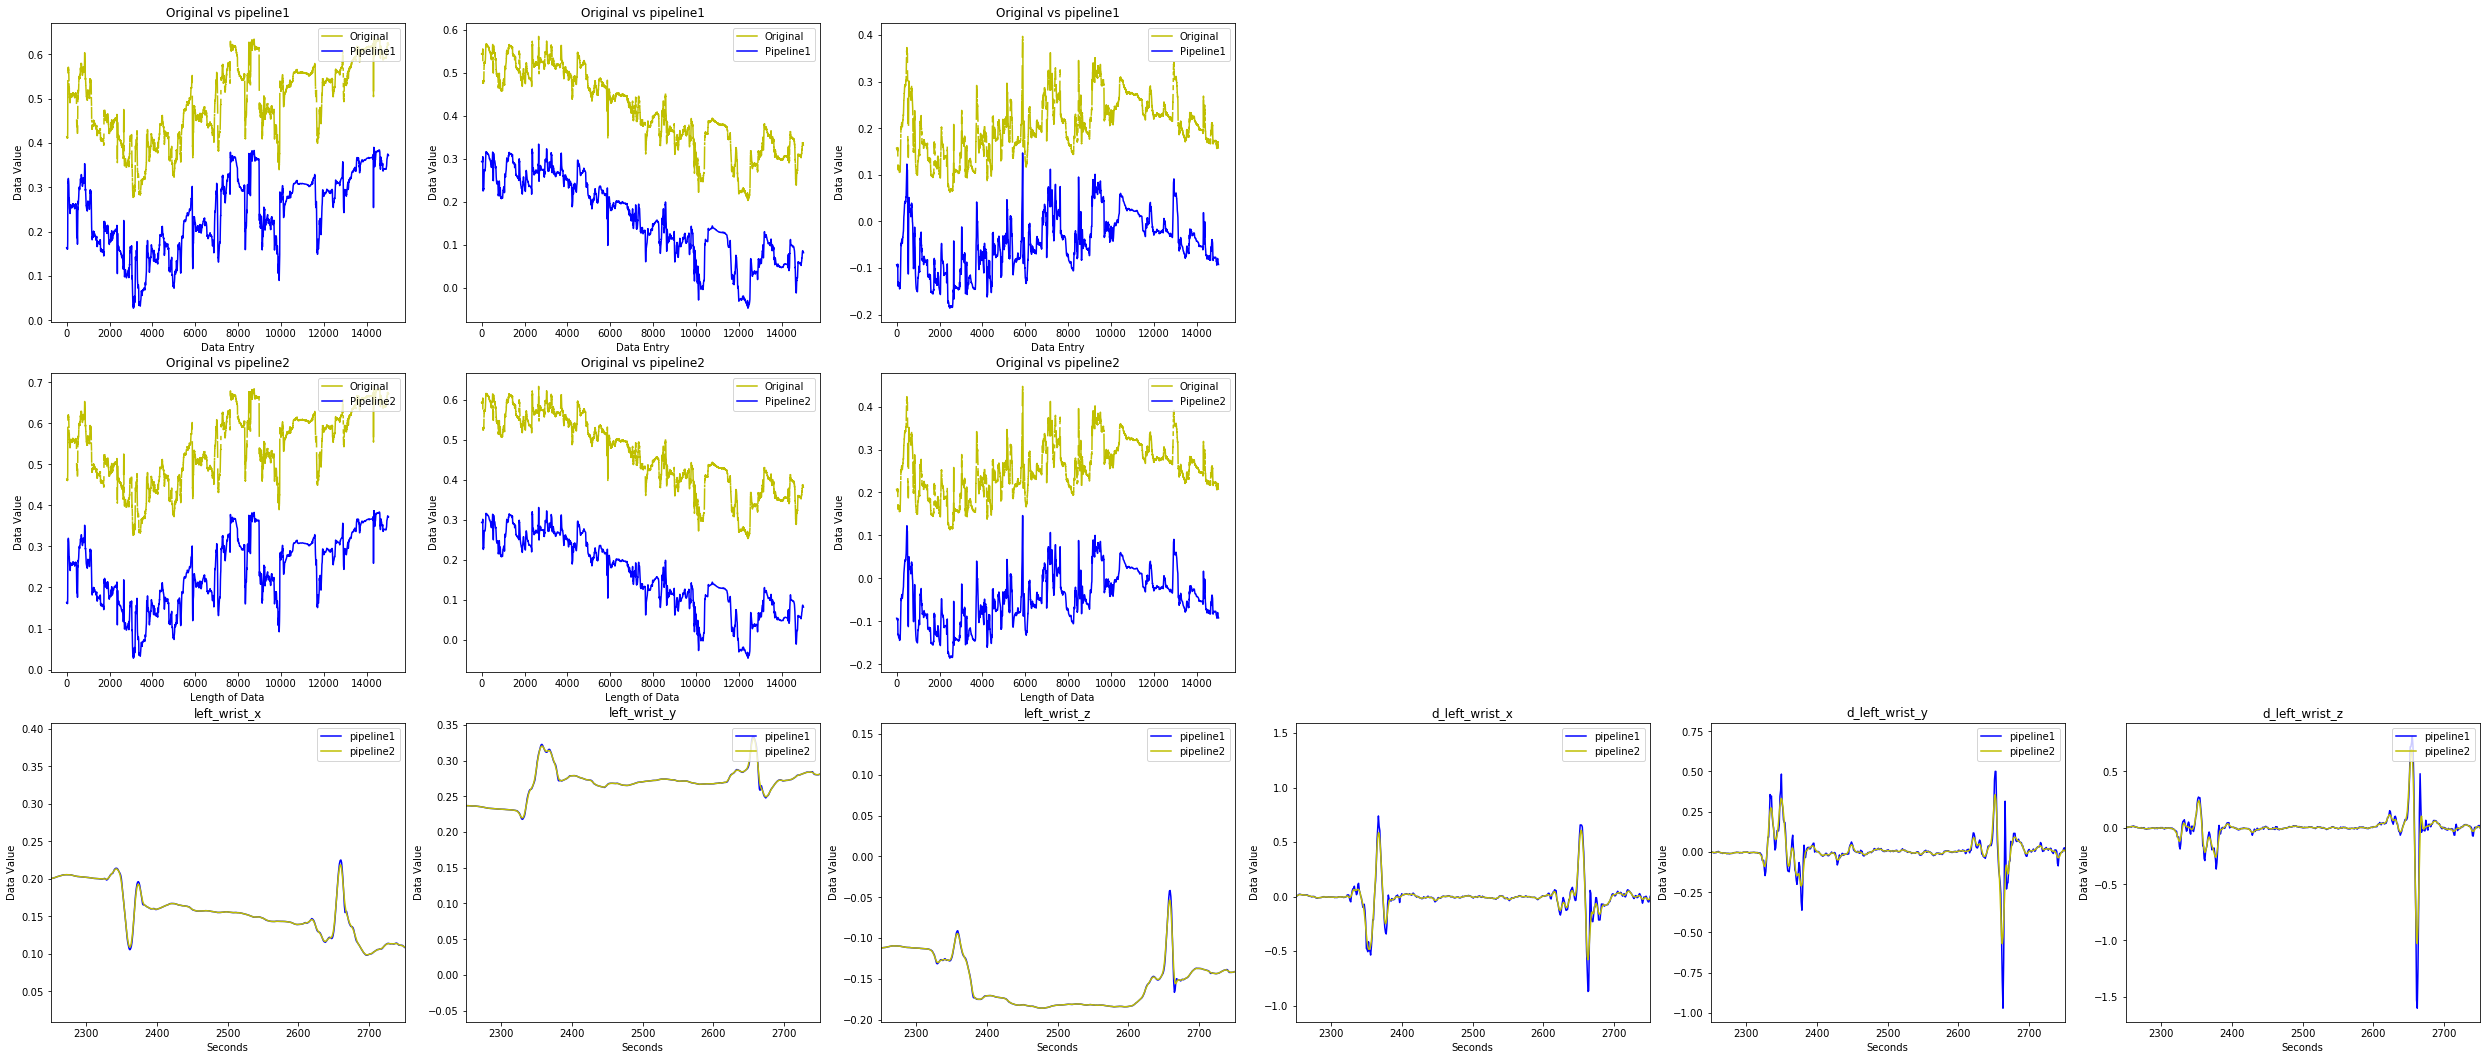

In [37]:
""" TODO
Construct plots comparing the raw data to the pre-processed data 
for each selected feature from both pipelines. For each selected 
feature, create a figure displaying the raw data and the cleaned 
data in the same subplot. The raw data should be shifted upwards 
to clearly observe where the gaps are filled in the cleaned data. 
There should be three subplots per feature figure. Each subplot 
is in a separate row.
    subplot(1) will compare the original raw data to the pipeline1 
               pre-processed data
    subplot(2) will compare the original raw data to the pipeline2 
               pre-processed data
    subplot(3) will compare pipeline1 to pipeline2. Set the x limit 
               to 45 and 55 seconds
For all subplots, include axis labels, legends and titles.
"""

#creates a copy of data to drop time
noTime = baby_data_raw.copy()
fig, axs = plt.subplots(3, len(noTime.columns.values)-1, figsize=(35, 15))
del noTime['time']
fig.tight_layout(pad=3.0)

#geting column names
origColNames = noTime.columns.values
babyDataNames = baby_data1.columns.values
from matplotlib import transforms
limit1 = np.where(time == 45)
limit2 = np.where(time == 55)

#loops through names to plot the data, transform is used to shit upward.
for i in range(len(origColNames)):
    #to clean up empty subplots
    if(origColNames[i] == babyDataNames[i]):
        axs[0][i].set_xlabel('Data Entry')
        axs[0][i].set_ylabel('Data Value')
        axs[0][i].set_title("Original vs pipeline1")
        transform = transforms.Affine2D().translate(0, 0.250) + axs[0][i].transData
        axs[0][i].plot(noTime[origColNames[i]], color='y', label='Original', transform=transform)
        axs[0][i].plot(baby_data1[babyDataNames[i]], color='b', label='Pipeline1')
        axs[0][i].legend(loc="upper right")
        axs[1][i].set_xlabel('Length of Data')
        transform = transforms.Affine2D().translate(0, 0.30) + axs[1][i].transData
        axs[1][i].set_ylabel('Data Value')
        axs[1][i].set_title("Original vs pipeline2")
        axs[1][i].plot(noTime[origColNames[i]], color='y', label='Original', transform=transform)
        axs[1][i].plot(baby_data2[babyDataNames[i]], color='b', label='Pipeline2')
        axs[1][i].legend(loc="upper right")
    else:
        fig.delaxes(axs[0][i])
        fig.delaxes(axs[1][i])
    axs[2][i].set_xlim(limit1[0], limit2[-1])
    axs[2][i].set_xlabel('Seconds')
    axs[2][i].set_ylabel('Data Value')
    axs[2][i].set_title(babyDataNames[i])
    axs[2][i].plot(baby_data1[babyDataNames[i]], color='b', label='pipeline1')
    axs[2][i].plot(baby_data2[babyDataNames[i]], color='y', label='pipeline2')
    axs[2][i].legend(loc="upper right")

DerivativeComputer(attribs=Index(['left_wrist_x', 'left_wrist_y', 'left_wrist_z'], dtype='object'),
                   dt=0.02, prefix='d_')

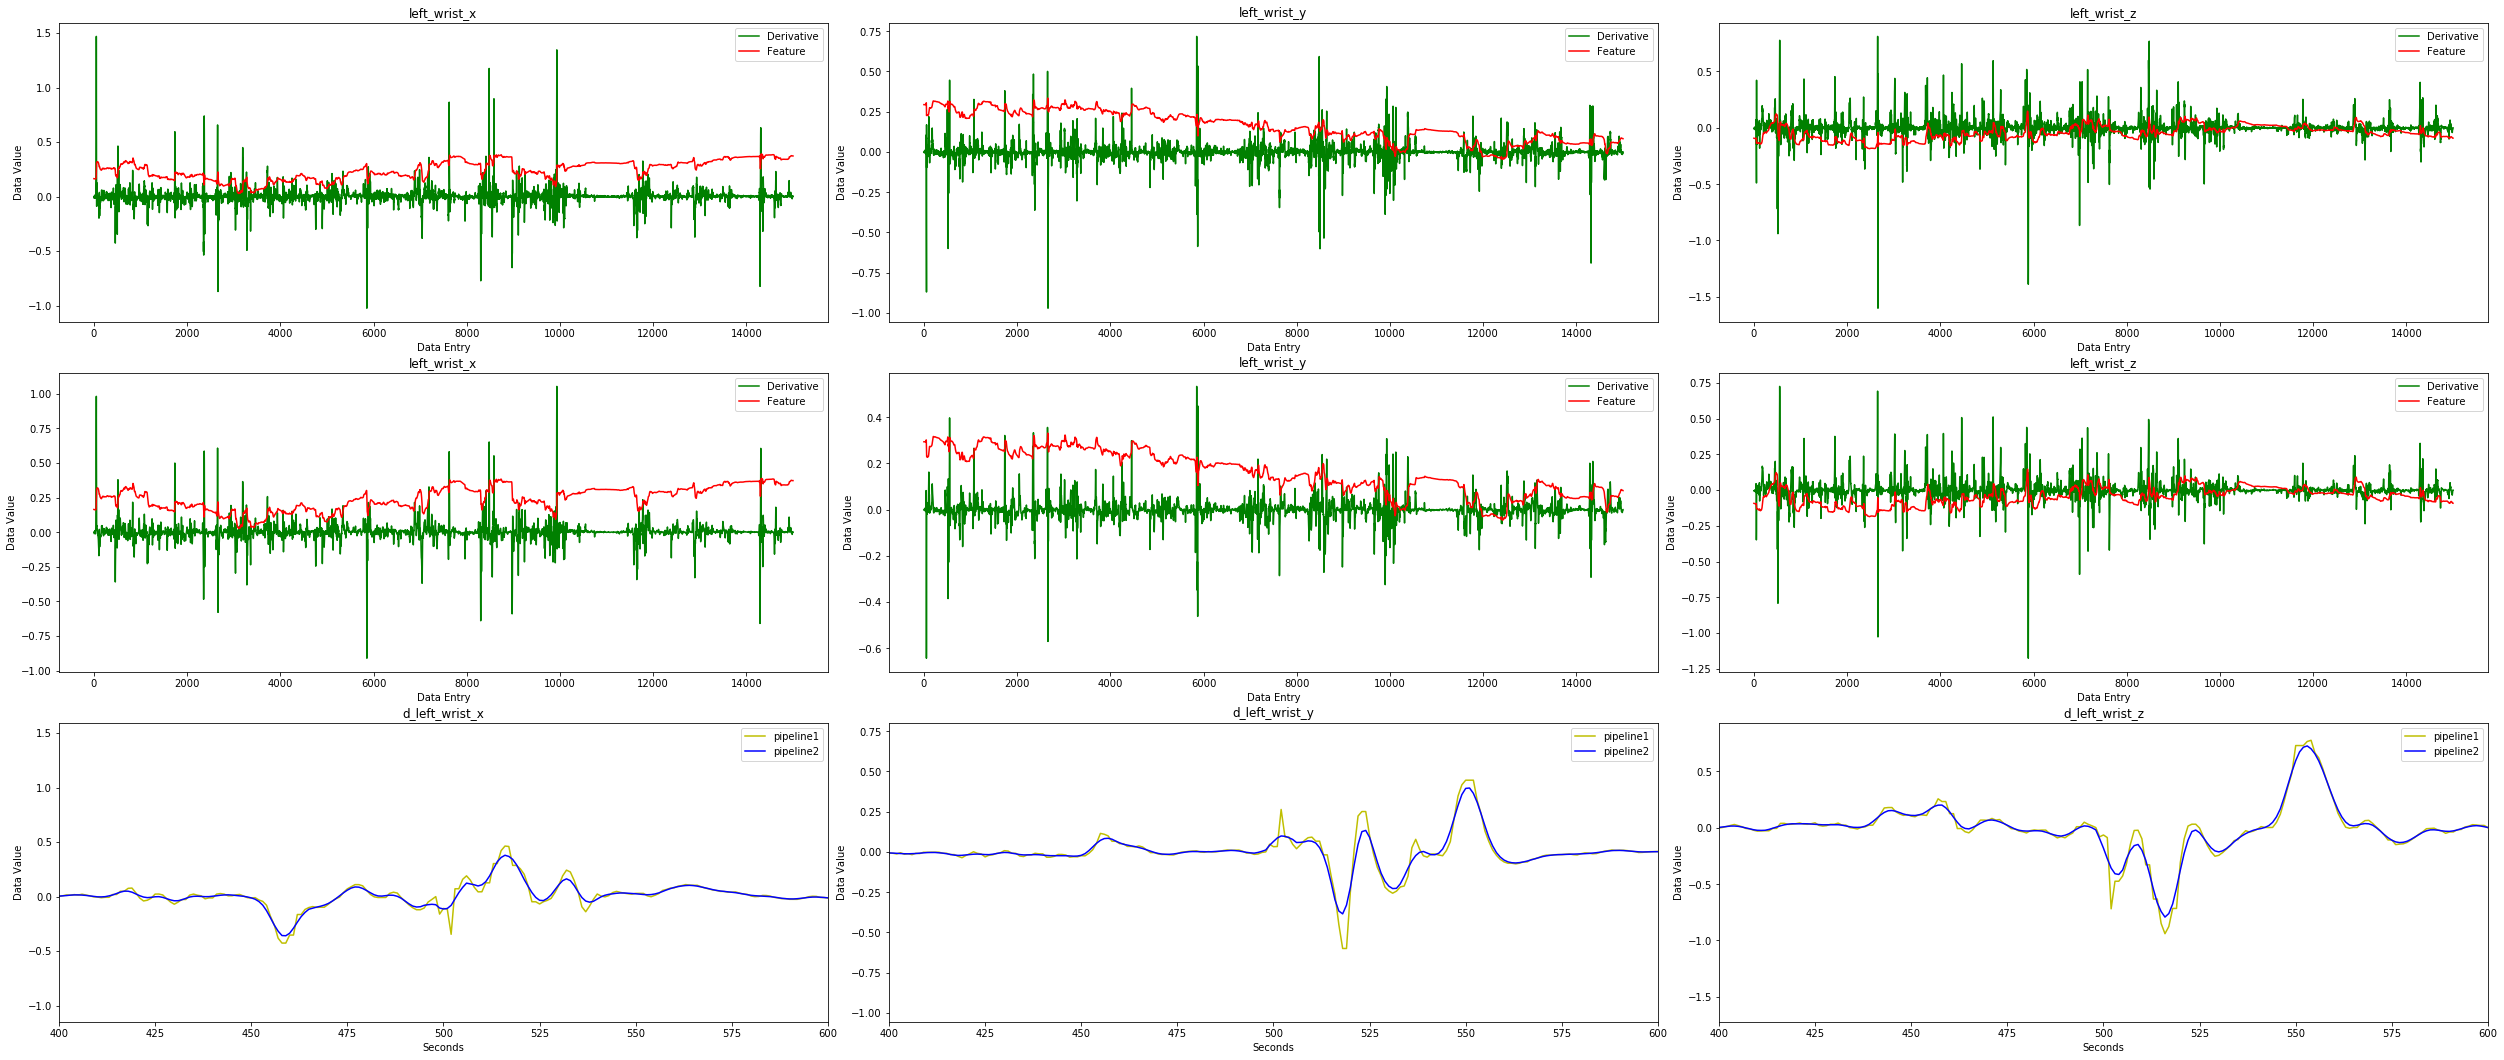

In [36]:
""" TODO
Construct plots for each feature presenting the feature and its 
derivative from both pipelines. Each figure should have 
3 subplots:
    1: the pipeline1 feature data and cooresponding derivative 
    2: the pipeline2 feature data and corresponding derivative
    3: pipeline1 derivative and pipeline2 derivative. Set the x limit 
       to 8 and 12 seconds.
For all subplots, include axis labels, legends and titles.
"""
#firstHalf are non derivative, lastHalf are derivative
firstHalf = babyDataNames[:3]
lastHalf = babyDataNames[3:]
fig, axs = plt.subplots(3, 3, figsize=(35, 15))
fig.tight_layout(pad=3.0)
#plots data
display(pipe1['derivative'])
limit1 = np.where(time == 8)
limit2 = np.where(time == 12)
for i in range(len(firstHalf)):
    axs[0][i].set_title(firstHalf[i])
    axs[0][i].set_xlabel('Data Entry')
    axs[0][i].set_ylabel('Data Value')
    axs[0][i].plot(baby_data1[lastHalf[i]], color='g', label="Derivative")
    axs[0][i].plot(baby_data1[firstHalf[i]], color='r',label="Feature")
    axs[0][i].legend(loc="upper right")
    axs[1][i].set_title(firstHalf[i])
    axs[1][i].set_xlabel('Data Entry')
    axs[1][i].set_ylabel('Data Value')
    axs[1][i].plot(baby_data2[lastHalf[i]], color='g', label="Derivative")
    axs[1][i].plot(baby_data2[firstHalf[i]], color='r', label="Feature")
    axs[1][i].legend(loc="upper right")
    axs[2][i].set_xlim(limit1[0], limit2[-1])
    axs[2][i].set_xlabel('Seconds')
    axs[2][i].set_ylabel('Data Value')
    axs[2][i].set_title(lastHalf[i])
    axs[2][i].plot(baby_data1[lastHalf[i]], color='y', label="pipeline1")
    axs[2][i].plot(baby_data2[lastHalf[i]], color='b', label="pipeline2")
    axs[2][i].legend(loc="upper right")